## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [ ]:
import string
import os
import numpy as np
from matplotlib import pyplot as plt

from IPython.display import clear_output
from random import sample
from tqdm import tqdm

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In [ ]:
rows = text

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = (''.join(text)).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
joined_set = set(text)
joined_set.add('<pad>')
joined_set
tokens = sorted(joined_set)

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
# dict <index>:<char>
token_to_idx = {token: index for index, token in enumerate(tokens)}
# dict <char>:<index>
idx_to_token = {token_to_idx[token] : token for token in tokens}

PAD_IDX=token_to_idx['<pad>']

In [ ]:
len(token_to_idx)
num_tokens=len(token_to_idx)

### Data preprocessing

In [ ]:
ban_chars = "!,?:.;"
def preproc(row):
    for char in ban_chars:
        row = row.replace(char, '')
    
    row = row.replace('\n', '')
    row = row.replace('\t', '')
    if len(row) > 0:
        return row.lower()

rows = [preproc(row) for row in rows]
rows = [r for r in rows if r is not None]

In [ ]:
rows

['  from fairest creatures we desire increase',
 "  that thereby beauty's rose might never die",
 '  but as the riper should by time decease',
 '  his tender heir might bear his memory',
 '  but thou contracted to thine own bright eyes',
 "  feed'st thy light's flame with self-substantial fuel",
 '  making a famine where abundance lies',
 '  thy self thy foe to thy sweet self too cruel',
 "  thou that art now the world's fresh ornament",
 '  and only herald to the gaudy spring',
 '  within thine own bud buriest thy content',
 "  and tender churl mak'st waste in niggarding",
 '    pity the world or else this glutton be',
 "    to eat the world's due by the grave and thee",
 '  ii',
 '  when forty winters shall besiege thy brow',
 "  and dig deep trenches in thy beauty's field",
 "  thy youth's proud livery so gazed on now",
 "  will be a tatter'd weed of small worth held",
 '  then being asked where all thy beauty lies',
 '  where all the treasure of thy lusty days;',
 '  to say within 

Max length: 60


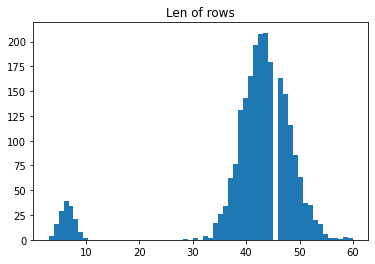

In [ ]:
plt.title('Len of rows')
plt.hist(list(map(len, rows)), bins=61);
print(f'Max length: {max(map(len, rows))}')
MAX_LENGTH = max(map(len, rows))

In [ ]:
def to_matrix(rows, max_len=None, pad=PAD_IDX, dtype='int32', batch_first = True):
    """Casts a list of rows into rnn-digestable matrix"""
    
    max_len = (max_len or max(map(len, rows))) + 1
    rows_ix = np.zeros([len(rows), max_len], dtype) + pad

    for i in range(len(rows)):
        line_ix = [token_to_idx[c] for c in rows[i]]
        rows_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        rows_ix = np.transpose(rows_ix)

    return rows_ix

In [ ]:
print('\n'.join(rows[::1000]))
print(to_matrix(rows[::1000]))

  from fairest creatures we desire increase
  for she hath no exchequer now but his
  he learn'd but surety-like to write for me
[[ 1  1 18 30 27 25  1 18 13 21 30 17 31 32  1 15 30 17 13 32 33 30 17 31
   1 35 17  1 16 17 31 21 30 17  1 21 26 15 30 17 13 31 17 11 11]
 [ 1  1 18 27 30  1 31 20 17  1 20 13 32 20  1 26 27  1 17 36 15 20 17 29
  33 17 30  1 26 27 35  1 14 33 32  1 20 21 31 11 11 11 11 11 11]
 [ 1  1 20 17  1 24 17 13 30 26  3 16  1 14 33 32  1 31 33 30 17 32 37  7
  24 21 23 17  1 32 27  1 35 30 21 32 17  1 18 27 30  1 25 17 11]]


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [ ]:
#will use F.one_hot(tensor, num_classes=6) + linear layer(Instead of embedding)

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [ ]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=32, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units# size if hiden state
        self.num_tokens = num_tokens
        
        self.linear = nn.Linear(num_tokens, embedding_size)#instead of embedding layer use one_hot + linear
        
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)#update in layer
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = F.one_hot(x, num_classes=self.num_tokens).type(torch.FloatTensor)
        x_emb = self.linear(x_emb)
        
        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x_emb, h_prev], dim=1) 
        h_next = self.rnn_update(x_and_h)
        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [ ]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss(ignore_index=PAD_IDX)
opt = torch.optim.Adam(char_rnn.parameters())
history = []
batch_size = 64
num_epoch = 2000

In [ ]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state) 
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

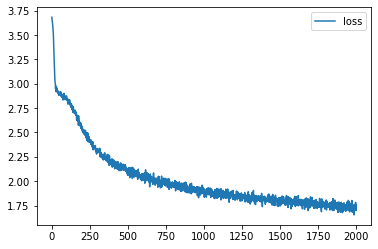

In [ ]:
%%time
for i in range(num_epoch):
    batch_ix = to_matrix(sample(rows, batch_size), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1] #--log od probs of next tokens
    actual_next_tokens = batch_ix[:, 1:] #real tokens
    
    loss = criterion(
      predictions_logp.contiguous().view(-1, len(tokens)),
      actual_next_tokens.contiguous().view(-1)
    )
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Plot the loss function (axis X: number of epochs, axis Y: loss function).

### Evaluating

In [ ]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if there are any characters
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        #use last token and prev hid state
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [ ]:
for _ in range(10):
    print(generate_sample(char_rnn, temperature=0.5, max_length=100))

  love be love in hat thou sime and the love and desperter yet mores to so from me like my love hen 
  so love thou ever for that are of then the and dearter the me make thou more trueds i to then hear
  but bith the pares of still she senter the your my seather thou thou her in me sumtir art as thou 
  o wir'd i parse then yet not manger more thee that the senge i dearthang the to prace that were se
  xxxviith the not whing the sparce thee whing that whing more thy sho conder thou thy love then hea
  for to and in lake the love the bating i stor'd thee beaut that of the sume the wert the preated h
  the with love thele and the all that beaut the whing thou thy enter the frewart dister live the be
  the pead the should sho love brown then own thee lime the shown thee to the corised with theart he
  hate brentressen that and the sell with with the sove be say one sell that in thee dear sing some 
  and the wate the song me with cont i mand my spill for thou so sho for than this not shou

**Переводчик выдал такое**, прикольно:

` любовь любовь в шапке ты Sime и любовь и desperter еще нравы, чтобы так от меня любовь моя курочка
так люби ты когда-нибудь за то, что имеют, то и dearter на мне ты больше trueds я то слышал
но у каждой пары по-прежнему она Сентер на свой seather мой еси ты ее в меня sumtir искусство как ты
о Дми бы мне разбирать тогда еще не яслях больше тебя, что Сенге я dearthang на працю, которые были ЮВ
xxxvi с тем, чтобы не хныкать, чтобы ты хныкал, чтобы хныкал больше, чем ты любишь, тогда он
для того, чтобы и в озеро Любви в мягчение и стор бы тебе, красавица, что в суме в Верт на preated ч
с любовью thele и все, что красотка на нытье яко Твое введите frewart dister жить будет
в дпжк должны шо любить Браун затем беру тебя извести показанному тебе на corised с тертом он
ненавижу brentressen, что и продавать с сове можно сказать одно продать что она и в тебе дорогая петь
и Уэйт песня мне с cont я требовать свои прольешь ты так шо по чем это не должно и й` 

In [ ]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase=' world', temperature=0.6))

 world my love the preave'd to forlon no doth in his stome o
 world trom thee so ell doth thine the an former all thou th
 world of to hee seat fair of my wortrome far hight thener l
 world for mank in the suplicker'd the thine this make thee 
 world more seesy when in thou my then me eyes in she woiv n
 world the summing that store do sterld spaint thee i were i
 world love as whit though the more your mesest the worth th
 world love not these a beal in to staints eed what to the s
 world the mine for is thes all whink to gart that and thee 
 world be me from the wall the though not then thy beast all


`мир моей любви preave бы, чтобы Ферлонг нет ли в его стерео
мир с тобою так хорошо ли твои бывшие хотя
мир в ее справедливой сиденье моего шкаф для высокой почти
мир для человечества suplicker бы то, что делают
мир больше семян, когда ты в мой-то мне глаза на сплетенные
мир суммирование, что магазин не стероид щадя тебя я я
мир любви, как если больше, вы должны На стоит
мир любви не этими мяч в святых нужно что з
мир шахте на это все, думал тяжело и
мир, будь мной со стены, хотя и не тогда, зверь весь`

In [ ]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase=' love', temperature=0.8))

 love so apting arl thid at frower not than strees thou shou
 love do gromecy lith or heart thoughtire hear and desterere
 love deart faedd in tounters will thith at an thy lover on 
 love so apon vose hace as in me praich which is live haten 
 loversh and stinoul live thee telf worther it mine with riv
 love of weest thesey old of liguting vet hes still wath and
 love of doth strees in and true fall oudy anter swie so say
 love fair my may the that that hath wiest angursby do thou 
 love henter mome that that hee bebet praintee ambert gaind 
 love do me biter hiser 'time sight thine to boughtle be wou


`люби мыльную жестяную повязку на третьем месте не хуже, чем улицы, которые ты должен
любить, делай громкие слова или сердечные мысли, сердце и дестерере
смерть любви, превратившаяся в охотников, будет дергаться на любителя, влюбленного в
любовь, так что на чьей расе, как во мне, приход, который является любовью, ненавидит
влюбленных и все еще живет там, самоценный, мой с рекой
любовь к сладостям, этим старым ветеринарам, за которыми он все еще наблюдает, и
любовь к обеим улицам, и правда, выпадают еще один удар, так что скажи
, что любовь справедлива, мой май, что у тебя есть ангерсби, любишь ли ты
хантера больше, чем то, что он победил прерию Альберта.
любовь сделает меня лучше в этот раз, правильная вещь, чтобы купленный лейбл был бы`

In [ ]:
temps = [0.4, 0.5, 0.6, 0.8, 1.0, 2.0]

for t in temps:
    print(generate_sample(char_rnn, max_length=40, seed_phrase=' ', temperature=t))

    my me with the wate the love heart t
  and fair they far that end the store t
    thee hate sear shall in true to sish
    for that this and mides be thich sly
  so ly yese wo chad wore insines meact 
  mame' warlk rouch fhzy nmacreouteiom w


`мое я с водой любящее сердце т
и справедливо, что они боятся, что магазин закончится
, потому что они ненавидят сирс-холл в верном блюде
для того, чтобы это и то, что
было только хитрым, и то, что чад носил стельки, означало
, что мама "ходит по рукам и ногам".`

Переводчик, конечно, справился с последними предложениями, однако явно многих слов в англиском словаре нет, с увеличением температуры возрастает хаотичность букв, модель больше импровизирует, а при маленькихт словах использует хорошо запомнившиеся ей слова.

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [ ]:
class CharLSTM(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=64, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.num_tokens = num_tokens
        self.emb = nn.Embedding(num_tokens, emb_size, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hid_states=None):
        #hid_states=(h_0, c_0)
        assert isinstance(x.data, torch.LongTensor)
        x_emb = self.emb(x)
        
        if hid_states is None:
            hid_states = self.initial_state(1)
            
        h_seq, hid_states = self.lstm(self.emb(x), hid_states)
        
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hid_states
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return (torch.zeros(1, batch_size, self.num_units, requires_grad=True),
                torch.zeros(1, batch_size, self.num_units, requires_grad=True))

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
model = CharLSTM()
opt = torch.optim.Adam(model.parameters())
history = []
criterion = nn.NLLLoss(ignore_index=PAD_IDX)
batch_size = 64
num_epoch = 1500

### check if all work correctly

In [ ]:
#check if all work correctly
batch_ix = to_matrix(sample(rows, 32), max_len=MAX_LENGTH)
batch_ix = torch.LongTensor(batch_ix)

logp_seq, _ = model(batch_ix, hid_states=model.initial_state(32))

# compute loss. 
loss = F.nll_loss(logp_seq[:, 1:].contiguous().view(-1, num_tokens), 
                  batch_ix[:, :-1].contiguous().view(-1))

loss.backward()

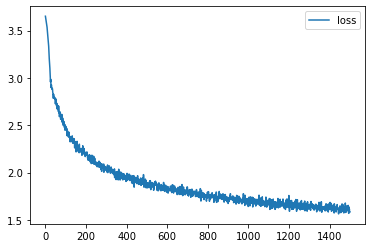

In [ ]:
for i in range(num_epoch):
    batch_ix = to_matrix(sample(rows, batch_size), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    
    logp_seq, hid_states = model(batch_ix, hid_states=model.initial_state(batch_size=batch_size))
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    
    loss = criterion(
      predictions_logp.contiguous().view(-1, len(tokens)),
      actual_next_tokens.contiguous().view(-1)
    )
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

**Вывод** Используя lstm добились меньшего loss'а на меньшем числе эпох. То есть долгосрочная память помогает очень сильно при генерации текста.

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
def generate_sample(model, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    hid_states = model.initial_state(1)
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        _, hid_states = model(x_sequence[:, i].view(1, 1), hid_states)
    #change the view for lstm
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        logp_next, hid_states = model(x_sequence[:, -1].view(1, 1), hid_states)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next.ravel())
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [ ]:
for _ in range(10):
    print(generate_sample(model, seed_phrase=' world', temperature=0.6))

 world deen the deeds have and the gultest thou art for this
 world to deself virt of my love thy beauty a freace am be t
 world and thee that i be stang that so love fair will love 
 world not the see promst the seet with my speed i blanst ca
 worlds you themprieft the self me of thee is my thee the fr
 world in that be sconse seeft i of thean of waster bind wit
 world and thee quite the ween in the canst for sport the re
 world where ill heart my beauty ow the suth be for my heart
 world and the loast stir the sull to live to me make ere ot
 world and or starves thy more reast a and where may that th


`мир, видимый в делах и робких, ты за этот
мир растворить рождения, моя любовь, красоту твою угощение очень плохо
мир и тебе, что мне странно, что так любят феи будут любить
мира не видят оперативное кресло с моей скоростью я волна
миры, о которых вы themprieft себя мне мой тебе плода
мир в это бра считают нужным Ан водных связываться с
мир и есть неделька в случае, если на спорт нет
мир, где жестокое сердце, моя красавица Ай Южно-быть для моего сердца
мира и самой низкой перемешать души, чтобы жить со мной делают другие
мир и или голодает тем больше остальных а и где может что то`

Смысл текста все еще не до конца ясен :), однако в словах меньше ошибок, присутсвует философский оттенок повествования.

In [ ]:
temps = [0.1, 0.2, 0.5, 1.0, 2.0]

for t in temps:
    print(generate_sample(model, seed_phrase=' ', temperature=t))

  the see the strange the strange the self the shall the wit
  and the string the world the should the self the with the 
  which i rid thee the will on and she breards the shall my 
  awfours live i now look i a spee; of sperfufsed intfrn yet
  wo on whit; rictu)e''t'lfe-keapc-brest; titmvertry blalstu


При повышении температуры связность ухудшается, появляются слова, которые сеть не встречала в исходном тексте. В коде предсказанные логарифмы веротностей деляется на температуру и берется softmax, от этого праматера напрямую зависит вероятность, с которой выбираются символы, при больших температурах эти вероятности будут примерно равны между собой, то есть больше рандома.

In [ ]:
model = CharLSTM()
opt = torch.optim.Adam(model.parameters())
history = []
criterion = nn.NLLLoss(ignore_index=PAD_IDX)
batch_size = 64
num_epoch = 2000

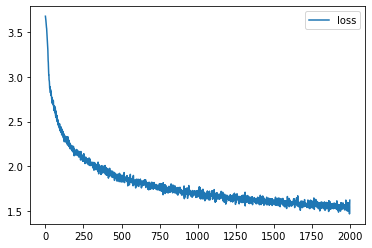

In [ ]:
def train_loop(model, num_epoch, batch_size, criterion, history):
    global MAX_LENGTH
    for i in range(num_epoch):
        batch_ix = to_matrix(sample(rows, batch_size), max_len=MAX_LENGTH)
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)


        logp_seq, hid_states = model(batch_ix, hid_states=model.initial_state(batch_size=batch_size))

        # compute loss
        predictions_logp = logp_seq[:, :-1]
        actual_next_tokens = batch_ix[:, 1:]

        loss = criterion(
          predictions_logp.contiguous().view(-1, len(tokens)),
          actual_next_tokens.contiguous().view(-1)
        )

        # train with backprop
        loss.backward()
        opt.step()
        opt.zero_grad()

        history.append(loss.data.numpy())
        if (i+1)%100==0:
            clear_output(True)
            plt.plot(history,label='loss')
            plt.legend()
            plt.grid(':')
            plt.show()

    assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

train_loop(model, num_epoch, batch_size, criterion, history)

In [ ]:
for _ in range(10):
    print(generate_sample(model, seed_phrase=' love', temperature=0.6))

 love and for the never sun my part it that still in so grie
 love the mine and alown on that his seed dectered and thee 
 love earsse love thou with in so so is of war beauty thy be
 love the soul to nake thee i the virter sweet is thou i str
 love to wanter for for show thy love and that shoo o i love
 love the love thou love chenther'd as that not cheventi's o
 love that that where i hast the do bris and these in the th
 love or conder a make and the the world by thou have where 
 love thou beauty fartess the your so should with the streas
 love the me that dayss the thee as possest a a have i how b


`любовь и за то, что я никогда не пел свою роль, это то, что все еще так сильно
люблю шахту и одинок в этом его семенном секторе, и
любовь, с которой ты любишь земное море, такова, какова их красота
, любить душу, чтобы сделать эти добродетели сладкими, это то, что я сильно люблю тебя.
люблю бродить, чтобы показать свою любовь и ту школу, которую я люблю.
люби любовь, которую ты любишь, как это не чевенти, о
, люби то, что там, где я принимаю добри, и это в третьей
любви, или подумай о том, чтобы сделать, и мир, который у тебя есть, где
ты любишь, красота, пригодность, твоя так должна быть со стрессом
тема любви, которая длится три дня, как обладаю а, имею ли я, как б`

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
torch.save(model.state_dict(), './model_lstm.pth')

In [ ]:
model_reload = CharLSTM()
model_reload.load_state_dict(torch.load('./model_lstm.pth'))

<All keys matched successfully>

In [ ]:
for _ in range(10):
    print(generate_sample(model_reload, seed_phrase=' love', temperature=0.8))

 love of prove; and to my lose thee that in the sorlly come 
 love and thou state the doth i thy mad of not costletimenes
 love' for in this loveir thou show seal know gave the worth
 love all tell their of the from that as fair the woll'ss th
 love thy dear thy masters never many creament to thee vinde
 love that a hall my sall self an o desceay the despress in 
 love welles the of beautite; a the tom so consters wir on t
 love in no mine how sorld love one in thee sould brow'd gri
 love thee thy peation vanting steck--therefounce to greain 
 love thou dold for shall more tenfends of on that thime whr


`любовь доказать; и, к моему потерять тебя, что в только
любовь а ты состоянии ли я им сделано не costletimenes
любовь для любовника ты показать уплотнение знаю, отдал стоит
любовь все расскажут их для того, как ярмарка на Уолл-го столетия
люблю твои дорогие мастера твое лечение видео
нравится, что в зале ключевые моей малой собственной узлов Эспрессо в
любовь Уэллс из красавиц; а раз так певуньи были на
любовь в nomine как надо любить одно в трех почвах сцепление Брауна
люблю тебя, твое прошение, желающее прилипнуть - от унции до зерна
любите это золото больше, чем друзей по этой теме, где`

Она все еще творит :)